In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# データ読み込み
DATA_DIR = './tracon01/'
train = pl.read_csv(DATA_DIR + 'train.csv')
test = pl.read_csv(DATA_DIR + 'test.csv')

print(train)
print(test)

# レポジトリ情報を読み取り
repo = pl.read_csv(DATA_DIR + 'repo.csv')

# repo_idをもとにレポジトリ情報を結合
train_merged = train.join(repo, on='repo_id', how='left')
test_merged = test.join(repo, on='repo_id', how='left')


def add_col(df, name, add):
    return df.with_columns(add.alias(name))


def get_readme_size(s):
    l = eval(s)
    for e in l:
        if e["name"] == "README.md":
            return e["size"]
    return 0


def get_file_size(s):
    l = eval(s)
    res = 0
    for e in l:
        res += e["size"]
    return res


train_merged = add_col(train_merged, "readme_size", train_merged["files"].map_elements(get_readme_size))
test_merged = add_col(test_merged, "readme_size", test_merged["files"].map_elements(get_readme_size))

train_merged = add_col(train_merged, "file_size", train_merged["files"].map_elements(get_file_size))
test_merged = add_col(test_merged, "file_size", test_merged["files"].map_elements(get_file_size))

readme_size_cnt = {}

for row in train_merged.iter_rows(named=True):
    readme_size_cnt[row["readme_size"]] = readme_size_cnt.get(row["readme_size"], 0) + 1
for row in test_merged.iter_rows(named=True):
    readme_size_cnt[row["readme_size"]] = readme_size_cnt.get(row["readme_size"], 0) + 1


def get_readme_count(readme_size):
    return readme_size_cnt[readme_size]


train_merged = add_col(train_merged, "readme_size_cnt", train_merged["readme_size"].map_elements(get_readme_count))
test_merged = add_col(test_merged, "readme_size_cnt", test_merged["readme_size"].map_elements(get_readme_count))

print(train_merged)

# repo urlを追加
train_merged = add_col(train_merged, "repo_url", train_merged["owner"] + "/" + train_merged["repo"])
test_merged = add_col(test_merged, "repo_url", test_merged["owner"] + "/" + test_merged["repo"])
# train_merged = train_merged.with_columns((train_merged["owner"] + "/" + train_merged["repo"]).alias("repo_url"))
# test_merged = test_merged.with_columns((test_merged["owner"] + "/" + test_merged["repo"]).alias("repo_url"))


shape: (3_683, 4)
┌─────────────────────────────────┬──────────────┬────────────────────────────────┬────────┐
│ repo_id                         ┆ owner        ┆ repo                           ┆ active │
│ ---                             ┆ ---          ┆ ---                            ┆ ---    │
│ str                             ┆ str          ┆ str                            ┆ bool   │
╞═════════════════════════════════╪══════════════╪════════════════════════════════╪════════╡
│ 543a877d-cb0c-4705-92f5-acaf04… ┆ dana-i2cat   ┆ opennaas                       ┆ false  │
│ 2c471519-698f-439f-a498-fc57d1… ┆ salesagility ┆ SuiteCRM                       ┆ true   │
│ 9535bc28-6bca-4843-be86-b634c2… ┆ fake-name    ┆ ReadableWebProxy               ┆ false  │
│ c9417209-8ae3-4352-b41e-838e19… ┆ AOSParadox   ┆ android_kernel_oneplus_msm8974 ┆ false  │
│ 0292a511-920f-483e-aeff-bf743c… ┆ ipti         ┆ br.tag                         ┆ true   │
│ …                               ┆ …            ┆ …

/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:44: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train_merged = add_col(train_merged, "readme_size", train_merged["files"].map_elements(get_readme_size))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:45: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  test_merged = add_col(test_merged, "readme_size", test_merged["files"].map_elements(get_readme_size))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:47: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train_merged = add_col(train

shape: (3_683, 9)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ repo_id    ┆ owner      ┆ repo      ┆ active ┆ … ┆ files     ┆ readme_si ┆ file_size ┆ readme_si │
│ ---        ┆ ---        ┆ ---       ┆ ---    ┆   ┆ ---       ┆ ze        ┆ ---       ┆ ze_cnt    │
│ str        ┆ str        ┆ str       ┆ bool   ┆   ┆ str       ┆ ---       ┆ i64       ┆ ---       │
│            ┆            ┆           ┆        ┆   ┆           ┆ i64       ┆           ┆ i64       │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 543a877d-c ┆ dana-i2cat ┆ opennaas  ┆ false  ┆ … ┆ [{'name': ┆ 2214      ┆ 18586024  ┆ 1         │
│ b0c-4705-9 ┆            ┆           ┆        ┆   ┆ '.gitigno ┆           ┆           ┆           │
│ 2f5-acaf04 ┆            ┆           ┆        ┆   ┆ re',      ┆           ┆           ┆           │
│ …          ┆            ┆           ┆        ┆   ┆ 'size'…   ┆         

/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:62: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(get_readme_count)
with this one instead:
  + s.replace_strict(readme_size_cnt)

  train_merged = add_col(train_merged, "readme_size_cnt", train_merged["readme_size"].map_elements(get_readme_count))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:62: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train_merged = add_col(train_merged, "readme_size_cnt", train_merged["readme_size"].map_elements(get_readme_count))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/4187326912.py:63: PolarsInefficientMapWarning: 
Series.map_elements i

In [2]:
# コミット情報を読み取り
print("コミット情報を読み取っています...")
commits = pl.read_csv(DATA_DIR + 'commits_sampled_10.csv')

print("コミット情報を集計します...")

from datetime import datetime as dt

repo_commit_cnt = {}
repo_latest_commit_date = {}
repo_commit_members = {}
repo_commit_message_sum = {}
repo_recent_commit_cnt = {}

for row in commits.iter_rows(named=True):
    # print(f"row.repo_names = {row.repo_names}")
    # 日付として Author Date を利用
    if row["author_date"] is None:
        continue
    date = dt.strptime(row["author_date"], '%Y-%m-%d %H:%M:%S').timestamp()
    for repo_name in eval(row["repo_names"]):
        # print(f"repo_name = {repo_name}")
        repo_commit_cnt[repo_name] = repo_commit_cnt.get(repo_name, 0) + 1
        repo_latest_commit_date[repo_name] = max(repo_latest_commit_date.get(repo_name, 0), date)
        if not repo_name in repo_commit_members:
            repo_commit_members[repo_name] = {}
        repo_commit_members[repo_name][row["author_name"]] = \
            repo_commit_members[repo_name].get(row["author_name"], 0) + 1
        if row["message"] is not None:
            repo_commit_message_sum[repo_name] = repo_commit_message_sum.get(repo_name, 0) + len(row["message"])
        if date > 1640995200 - 31 * 24 * 60 * 60:  # 2022/1/1 = 1640995200
            repo_recent_commit_cnt[repo_name] = repo_recent_commit_cnt.get(repo_name, 0) + 1

repo_commit_cnt_df = pl.DataFrame({"repo_url": repo_commit_cnt.keys(), "n_commits": repo_commit_cnt.values()})
repo_latest_commit_date_df = pl.DataFrame(
    {"repo_url": repo_latest_commit_date.keys(), "last_commit_date": repo_latest_commit_date.values()})
repo_commit_members_df = pl.DataFrame(
    {
        "repo_url": repo_commit_members.keys(),
        "n_commit_members": [len(e) for e in repo_commit_members.values()],
        "first_author_ratio": [
            max(e) / sum(e) if len(e) != 0 else 0 for e in
            [sorted(list(e.values())) for e in repo_commit_members.values()]
        ],
    }
)
repo_commit_message_sum_df = pl.DataFrame(
    {"repo_url": repo_commit_message_sum.keys(), "len_commit_messages": repo_commit_message_sum.values()}
)
repo_recent_commit_cnt_df = pl.DataFrame(
    {"repo_url": repo_recent_commit_cnt.keys(), "n_recent_commits": repo_recent_commit_cnt.values()}
)
# print(repo_commit_cnt_df)

print("コミット情報を結合します...")

print(train_merged)
print(repo_commit_cnt_df)
train_merged = train_merged.join(repo_commit_cnt_df, on='repo_url', how='left')
test_merged = test_merged.join(repo_commit_cnt_df, on='repo_url', how='left')

train_merged = train_merged.join(repo_latest_commit_date_df, on='repo_url', how='left')
test_merged = test_merged.join(repo_latest_commit_date_df, on='repo_url', how='left')

train_merged = train_merged.join(repo_commit_members_df, on='repo_url', how='left')
test_merged = test_merged.join(repo_commit_members_df, on='repo_url', how='left')

train_merged = train_merged.join(repo_commit_message_sum_df, on='repo_url', how='left')
test_merged = test_merged.join(repo_commit_message_sum_df, on='repo_url', how='left')

train_merged = train_merged.join(repo_recent_commit_cnt_df, on='repo_url', how='left')
test_merged = test_merged.join(repo_recent_commit_cnt_df, on='repo_url', how='left')

print("コミット情報を読み取れました")


コミット情報を読み取っています...
コミット情報を集計します...
コミット情報を結合します...
shape: (3_683, 10)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ repo_id    ┆ owner      ┆ repo      ┆ active ┆ … ┆ readme_si ┆ file_size ┆ readme_si ┆ repo_url  │
│ ---        ┆ ---        ┆ ---       ┆ ---    ┆   ┆ ze        ┆ ---       ┆ ze_cnt    ┆ ---       │
│ str        ┆ str        ┆ str       ┆ bool   ┆   ┆ ---       ┆ i64       ┆ ---       ┆ str       │
│            ┆            ┆           ┆        ┆   ┆ i64       ┆           ┆ i64       ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 543a877d-c ┆ dana-i2cat ┆ opennaas  ┆ false  ┆ … ┆ 2214      ┆ 18586024  ┆ 1         ┆ dana-i2ca │
│ b0c-4705-9 ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆ t/opennaa │
│ 2f5-acaf04 ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆ s         │
│ …          ┆       

In [3]:
print("issue情報を読み取っています...")
issues = pl.read_csv(DATA_DIR + 'issues.csv')
print(issues)

print("issue情報を加工しています...")

issue_count_map = {}
issue_open_count_map = {}
repo_latest_closed_issue_map = {}
issue_message_len_map = {}
for row in issues.iter_rows(named=True):
    issue_count_map[row["repo_id"]] = issue_count_map.get(row["repo_id"], 0) + 1
    if row["state"] == 'open':
        issue_open_count_map[row["repo_id"]] = issue_open_count_map.get(row["repo_id"], 0) + 1
    else:
        if row["closed_at"] is not None:
            date = dt.fromisoformat(row["closed_at"]).timestamp()
            repo_latest_closed_issue_map[row["repo_id"]] = max(repo_latest_closed_issue_map.get(row["repo_id"], 0),
                                                               date)
    if row["body"] is not None:
        issue_message_len_map[row["repo_id"]] = issue_message_len_map.get(row["repo_id"], 0) + len(row["body"])
issue_count_df = pl.DataFrame({"repo_id": issue_count_map.keys(), "n_issues": issue_count_map.values()})
issue_open_count_df = pl.DataFrame(
    {"repo_id": issue_open_count_map.keys(), "n_open_issues": issue_open_count_map.values()})
repo_latest_closed_issue_df = pl.DataFrame(
    {"repo_id": repo_latest_closed_issue_map.keys(), "latest_closed_issue": repo_latest_closed_issue_map.values()}
)
issue_message_len_df = pl.DataFrame(
    {"repo_id": issue_message_len_map.keys(), "issue_message_len": issue_message_len_map.values()}
)

print("issue情報を結合しています...")

train_merged = train_merged.join(issue_count_df, on='repo_id', how='left')
test_merged = test_merged.join(issue_count_df, on='repo_id', how='left')

train_merged = train_merged.join(issue_open_count_df, on='repo_id', how='left')
test_merged = test_merged.join(issue_open_count_df, on='repo_id', how='left')

train_merged = train_merged.join(repo_latest_closed_issue_df, on='repo_id', how='left')
test_merged = test_merged.join(repo_latest_closed_issue_df, on='repo_id', how='left')

train_merged = add_col(train_merged, "issue_open_ratio", train_merged["n_open_issues"] / train_merged["n_issues"])
test_merged = add_col(test_merged, "issue_open_ratio", test_merged["n_open_issues"] / test_merged["n_issues"])

train_merged = train_merged.join(issue_message_len_df, on='repo_id', how='left')
test_merged = test_merged.join(issue_message_len_df, on='repo_id', how='left')

train_merged = add_col(train_merged, "ave_issue_body_len",
                       train_merged["issue_message_len"] / train_merged["n_issues"]).fill_null(0).fill_nan(0)
test_merged = add_col(test_merged, "ave_issue_body_len",
                      test_merged["issue_message_len"] / test_merged["n_issues"]).fill_null(0).fill_nan(0)

print("issue情報の取り込みが完了しました")


issue情報を読み取っています...
shape: (2_073_237, 8)
┌────────────┬────────────┬────────┬────────────┬────────────┬────────────┬────────────┬───────────┐
│ issue_id   ┆ repo_id    ┆ state  ┆ created_at ┆ closed_at  ┆ opened_by  ┆ title      ┆ body      │
│ ---        ┆ ---        ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│ str        ┆ str        ┆ str    ┆ str        ┆ str        ┆ str        ┆ str        ┆ str       │
╞════════════╪════════════╪════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ 8d0cab45cf ┆ e9dc25f7-e ┆ open   ┆ 2020-04-17 ┆ null       ┆ sagun786   ┆ Installati ┆ After I   │
│ ad44d1bb68 ┆ 8e0-48fb-8 ┆        ┆ T07:49:25+ ┆            ┆            ┆ on Bug on  ┆ run the   │
  │da817f7d7 ┆ 4a0-cbba44 ┆        ┆ 00:00      ┆            ┆            ┆ AWS        ┆ command
│ …          ┆ …          ┆        ┆            ┆            ┆            ┆ Lights…    ┆ ./scr…    │
│ fdb960961c ┆ e9dc25f7-e ┆ closed ┆ 2018-02-27 ┆ 201

In [4]:

print("PR情報を読み取っています...")
issues = pl.read_csv(DATA_DIR + 'pulls.csv')

print("PR情報を加工しています...")

pull_count_map = {}
pull_open_count_map = {}
for row in issues.iter_rows(named=True):
    pull_count_map[row["repo_id"]] = pull_count_map.get(row["repo_id"], 0) + 1
    if row["state"] == 'open':
        pull_open_count_map[row["repo_id"]] = pull_open_count_map.get(row["repo_id"], 0) + 1
pull_count_df = pl.DataFrame({"repo_id": pull_count_map.keys(), "n_pulls": pull_count_map.values()})
pull_open_count_df = pl.DataFrame(
    {"repo_id": pull_open_count_map.keys(), "n_open_pulls": pull_open_count_map.values()}
)

print("PR情報を結合しています...")

train_merged = train_merged.join(pull_count_df, on='repo_id', how='left').fill_null(0)
test_merged = test_merged.join(pull_count_df, on='repo_id', how='left').fill_null(0)

train_merged = train_merged.join(pull_open_count_df, on='repo_id', how='left').fill_null(0)
test_merged = test_merged.join(pull_open_count_df, on='repo_id', how='left').fill_null(0)

print(train_merged["n_pulls"])
print(train_merged["n_open_pulls"])

train_merged = add_col(train_merged, "pull_open_ratio", train_merged["n_open_pulls"] / (train_merged["n_pulls"] + 0.01))
test_merged = add_col(test_merged, "pull_open_ratio", test_merged["n_open_pulls"] / (test_merged["n_pulls"] + 0.01))

print(train_merged["pull_open_ratio"])
print("PR情報の取り込みが完了しました")

PR情報を読み取っています...
PR情報を加工しています...
PR情報を結合しています...
shape: (3_683,)
Series: 'n_pulls' [i64]
[
	1000
	4457
	0
	3
	44
	…
	0
	19
	576
	27
	117
]
shape: (3_683,)
Series: 'n_open_pulls' [i64]
[
	1000
	4457
	0
	3
	44
	…
	0
	19
	576
	27
	117
]
shape: (3_683,)
Series: 'pull_open_ratio' [f64]
[
	0.99999
	0.999998
	0.0
	0.996678
	0.999773
	…
	0.0
	0.999474
	0.999983
	0.99963
	0.999915
]
PR情報の取り込みが完了しました


In [5]:

# 要素数を取得する関数
def list_len(s: str):
    return s.count(',')


# 各データの "n_stars" に "stars" の要素数をいれる
train_merged = add_col(train_merged, "n_stars", train_merged["stars"].map_elements(list_len))
test_merged = add_col(test_merged, "n_stars", test_merged["stars"].map_elements(list_len))
# train_merged["n_stars"] = train_merged["stars"].apply(list_len)
# test_merged["n_stars"] = test_merged["stars"].apply(list_len)

train_merged = add_col(train_merged, "n_recent_stars", train_merged["stars"].map_elements(
    lambda x: len(list(
        filter(
            # 2022/1/1 = 1640995200
            lambda y: dt.fromisoformat(y["created_at"]).timestamp() > 1640995200 - 31 * 24 * 60 * 60,
            eval(x)
        )
    ))
))
test_merged = add_col(test_merged, "n_recent_stars", test_merged["stars"].map_elements(list_len))

# 各データの "n_files" に "files" の要素数をいれる
train_merged = add_col(train_merged, "n_files", train_merged["files"].map_elements(list_len))
test_merged = add_col(test_merged, "n_files", test_merged["files"].map_elements(list_len))
# train_merged["n_files"] = train_merged["files"].apply(list_len)
# test_merged["n_files"] = test_merged["files"].apply(list_len)

# n_starsの分布を表示
# plt.hist(train_merged['n_stars'], bins=50, alpha=0.5, label='train', log=True)
# plt.hist(test_merged['n_stars'], bins=50, alpha=0.5, label='test', log=True)
# plt.show()

# n_filesの分布を表示
# plt.hist(train_merged['n_files'], bins=50, alpha=0.5, label='train', log=True)
# plt.hist(test_merged['n_files'], bins=50, alpha=0.5, label='test', log=True)
# plt.legend()
# plt.show()

# "star_file_ratio" に n_files / n_stars を代入 (スターが多いほど小さく、ファイルが多いほど大きくなる)
train_merged = add_col(train_merged, "star_file_ratio", train_merged["n_files"] / train_merged["n_stars"])
test_merged = add_col(test_merged, "star_file_ratio", test_merged["n_files"] / test_merged["n_stars"])
# train_merged["star_file_ratio"] = train_merged["n_files"] / train_merged["n_stars"]
# test_merged["star_file_ratio"] = test_merged["n_files"] / test_merged["n_stars"]

# "file_par_commit" に n_files / n_commits を代入 (commitあたりの平均ファイル数)
train_merged = add_col(train_merged, "file_par_commit", train_merged["n_files"] / train_merged["n_commits"])
test_merged = add_col(test_merged, "file_par_commit", test_merged["n_files"] / test_merged["n_commits"])
# train_merged["file_par_commit"] = train_merged["n_files"] / train_merged["n_commits"]
# test_merged["file_par_commit"] = test_merged["n_files"] / test_merged["n_commits"]

train_merged = add_col(train_merged, "star_par_commit", train_merged["n_stars"] / train_merged["n_commits"])
test_merged = add_col(test_merged, "star_par_commit", test_merged["n_stars"] / test_merged["n_commits"])

import math

# n_issues はlogを取ったほうが扱いやすい値なので操作
# train_merged = add_col(train_merged, "n_issues_log", train_merged["n_issues"].map_elements(math.log))
# test_merged = add_col(test_merged, "n_issues_log", test_merged["n_issues"].map_elements(math.log))
# train_merged["n_issues_log"] = train_merged["n_issues"].apply(math.log)
# test_merged["n_issues_log"] = test_merged["n_issues"].apply(math.log)


/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/1105097667.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train_merged = add_col(train_merged, "n_stars", train_merged["stars"].map_elements(list_len))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/1105097667.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  test_merged = add_col(test_merged, "n_stars", test_merged["stars"].map_elements(list_len))
/var/folders/h3/81vzcnps2q3g4jrtz6_5099m0000gn/T/ipykernel_18617/1105097667.py:12: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train_merged = add_col(train_merged, "n_recent_stars

学習データの数: 2762 検証データの数: 921
学習データの数: 2762 検証データの数: 921
学習データの数: 2762 検証データの数: 921
学習データの数: 2763 検証データの数: 920
[LightGBM] [Info] Number of positive: 741, number of negative: 2021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4890
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268284 -> initscore=-1.003347
[LightGBM] [Info] Start training from score -1.003347
[LightGBM] [Info] Number of positive: 740, number of negative: 2022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4887
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pav

/Users/zoi_dayo/ghq/github.com/ZOI-dayo/traP-Nikkei-2025/venv/lib/python3.13/site-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


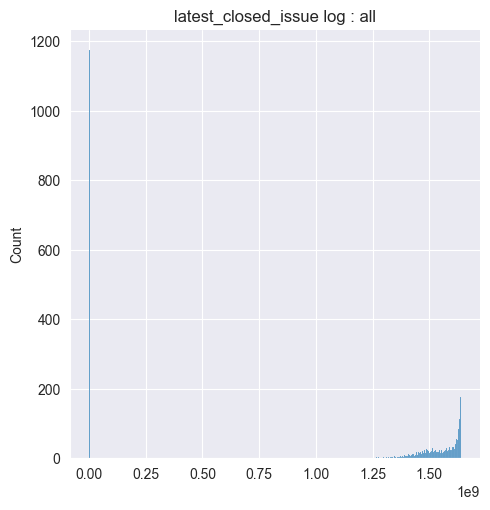

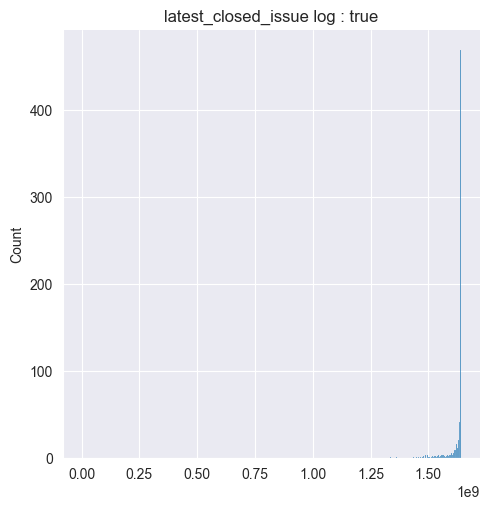

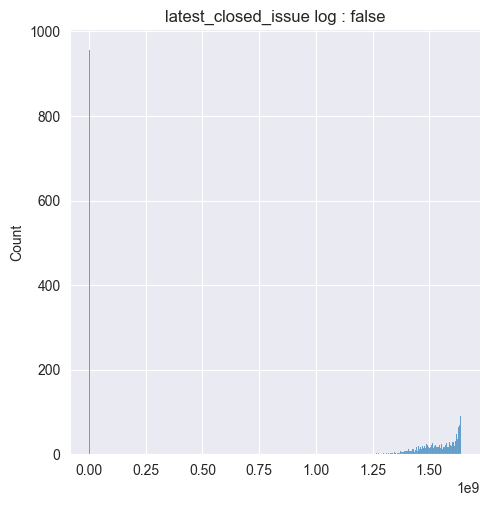

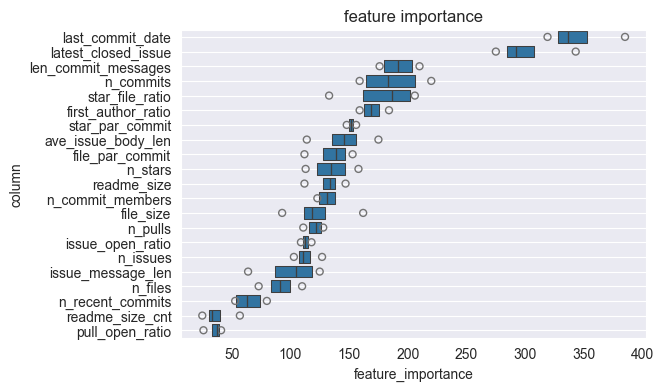

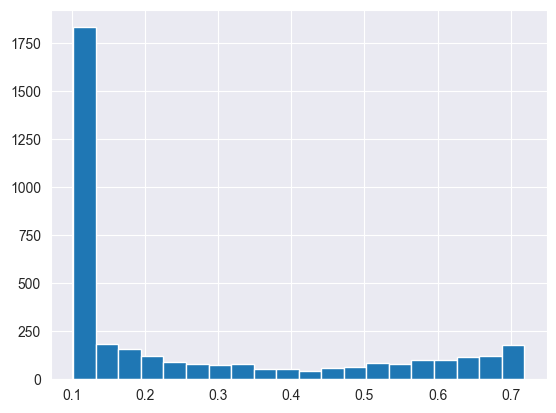

/Users/zoi_dayo/ghq/github.com/ZOI-dayo/traP-Nikkei-2025/venv/lib/python3.13/site-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


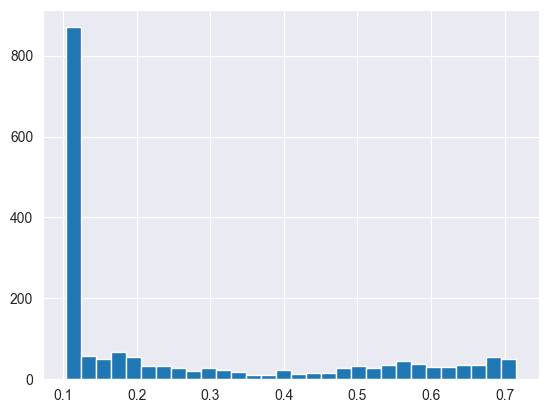

In [10]:

import seaborn as sns


def show_dist(df, key, log):
    sns.displot(df[key], kde=False, rug=False, bins=500, log_scale=10 if log else None).set(title=f"{key} log : all")
    sns.displot(df.filter(pl.col("active") == True)[key], kde=False, rug=False, bins=500,
                log_scale=10 if log else None).set(
        title=f"{key} log : true")
    sns.displot(df.filter(pl.col("active") == False)[key], kde=False, rug=False, bins=500,
                log_scale=10 if log else None).set(
        title=f"{key} log : false")


# fileの個数分布を表示
# show_dist(train_merged, "n_files")
# starの個数分布を表示
# show_dist(train_merged, "n_stars")

# show_dist(train_merged, "star_file_ratio")

# show_dist(train_merged, "n_commits")

# show_dist(train_merged, "file_par_commit")

show_dist(train_merged, "latest_closed_issue", False)

# KFoldでデータを分割
kf = KFold(n_splits=4, shuffle=True, random_state=34)

# 学習対象の行
use_cols = ["n_stars", "n_files", "star_file_ratio", "n_commits", "file_par_commit", "last_commit_date",
            "n_commit_members", "n_issues", "n_pulls", "readme_size", "readme_size_cnt", "latest_closed_issue",
            "file_size", "issue_open_ratio", "pull_open_ratio", "len_commit_messages", "star_par_commit",
            "n_recent_commits", "issue_message_len", "ave_issue_body_len", "first_author_ratio"]
target_col = "active"

for train_index, valid_index in kf.split(train_merged):
    train_data = train_merged[train_index]
    valid_data = train_merged[valid_index]
    print("学習データの数:", len(train_data), "検証データの数:", len(valid_data))

import lightgbm as lgb


# 各分割をもらって、lightgbm のモデルを訓練して訓練した後のモデルを返す関数
def train_fold(train_X: pd.DataFrame, train_y: pd.Series, valid_X: pd.DataFrame, valid_y: pd.Series,
               trial) -> lgb.Booster:
    # データセットを作成
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)

    # https://zenn.dev/robes/articles/d53ff6d665650f
    # {'learning_rate': 0.036710796431638056, 'num_leaves': 74, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 21, 'bagging_fraction': 0.1505235263266912, 'bagging_freq': 6, 'feature_fraction': 0.9944044553565908}
    # {'learning_rate': 0.035829155667069366, 'num_leaves': 99, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 47, 'bagging_fraction': 0.395652389722927, 'bagging_freq': 5, 'feature_fraction': 0.9581394359092842}
    params = {
        # 二値分類として解く
        'objective': 'binary',
        # 評価指標として auc と accuracy を使う
        'metric': ['binary_logloss', 'binary_error'],
        # 'learning_rate':
        # # trial.suggest_uniform('learning_rate', 0.01, 0.05),
        #     0.036,
        # 'n_estimators': 1000,
        # 'importance_type': 'gain',
        # 'num_leaves':
        # # trial.suggest_int('num_leaves', 10, 100),
        #     90,
        # 'min_data_in_leaf':
        # # trial.suggest_int('min_data_in_leaf', 5, 50),
        #     30,
        # 'min_sum_hessian_in_leaf':
        # # trial.suggest_int('min_sum_hessian_in_leaf', 5, 50),
        #     35,
        # 'lambda_l1': 0,
        # 'lambda_l2': 0,
        # 'bagging_fraction':
        # # trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        #     0.3,
        # 'bagging_freq':
        # # trial.suggest_int('bagging_freq', 0, 10),
        #     5,
        # 'feature_fraction':
        # # trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        #     0.98,
        # 'random_seed': 42
        # # --- --- ---
        "learning_rate": 0.01,
        'feature_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'num_leaves': 31,
        'random_state': 0,
        'num_iterations': 100,
    }

    # 学習. auc が 100ステップ以上改善しないなら打ち切るように設定する
    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid])

    return model


def learn(trial):
    # 各分割で学習した結果をいれた
    models = []

    for train_index, valid_index in kf.split(train_merged):
        train_data = train_merged[train_index]
        valid_data = train_merged[valid_index]

        train_X = train_data[use_cols].to_pandas()
        train_y = train_data[target_col].to_pandas()

        valid_X = valid_data[use_cols].to_pandas()
        valid_y = valid_data[target_col].to_pandas()

        model = train_fold(train_X, train_y, valid_X, valid_y, trial)

        models.append(model)

    # `oof_pred` に今回訓練したモデルたちによる予測結果を格納する

    oof_pred = np.zeros(len(train_merged))

    for i, (train_index, valid_index) in enumerate(kf.split(train_merged)):
        # バリデーションデータを取り出す
        valid_data = train_merged[valid_index]
        valid_X = valid_data[use_cols]

        # 予測結果を出力
        oof_pred[valid_index] = models[i].predict(valid_X)

    from sklearn.metrics import roc_auc_score, roc_curve

    score = roc_auc_score(train_merged["active"], oof_pred)

    print("score: ", score)
    # return score

    # ROC 曲線のプロット
    # fpr, tpr, thresholds = roc_curve(train_merged["active"], oof_pred)
    #
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {score}')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # ランダムな分類器の基準線
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("ROC Curve")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return score, models, oof_pred


def objective(trial):
    score, models, oof_pred = learn(trial)
    return score


# import optuna
#
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=300)
#
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
#
# exit(0)

score, models, oof_pred = learn(None)

import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(models: list):
    feature_importance = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    order = feature_importance.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',
                                                                                           ascending=False).index

    plt.figure(figsize=(6, 4))
    sns.boxenplot(data=feature_importance, x='feature_importance', y='column', order=order)
    plt.title('feature importance')
    plt.grid()
    plt.show()


# 各データをどれだけ重視したか見る
plot_importance(models)

# 予測値の分布を表示
plt.hist(oof_pred, bins=20)
plt.show()

from sklearn.metrics import confusion_matrix

# 提出

sample_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

pred = np.zeros(sample_sub.shape[0])

for model in models:
    pred += model.predict(test_merged[use_cols])

pred /= len(models)

sample_sub["pred"] = pred

plt.hist(pred, bins=30)
plt.show()

sample_sub.to_csv("submission.csv", index=False)
